In [36]:
using BenchmarkTools

import PyPlot

using PyCall
@pyimport pickle

In [190]:
# Calculate distance in meters between two points (ϕ1, λ1) and (ϕ2, λ2)
# on the Earth's surface using the haversine formula. ϕ denotes the latitude
# while λ denotes the longitude.
# See: http://www.movable-type.co.uk/scripts/latlong.html
function haversine_distance(ϕ1, λ1, ϕ2, λ2, R)
    Δϕ = ϕ2 - ϕ1
    Δλ = λ2 - λ1
    a = sinpi(Δϕ / 360.0f0)^2 + cospi(ϕ1 / 180.0f0) * cospi(ϕ2 / 180.0f0) * sinpi(Δλ / 360.0f0)^2
    # c = 2.0f0 * atan(√a, √(1-a))
    c = 2.0f0 * asin(min(1.0f0, √a))
    R*c
end

haversine_distance (generic function with 1 method)

In [191]:
function haversine_distance32(lat1::Float32, lon1::Float32, lat2::Float32, lon2::Float32, radius::Float32)
    c1 = cospi(lat1 / 180.0f0)
    c2 = cospi(lat2 / 180.0f0)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    d1 = sinpi(dlat / 360.0f0)
    d2 = sinpi(dlon / 360.0f0)
    t = d2 * d2 * c1 * c2
    a = d1 * d1 + t
    c = 2.0f0 * asin(min(1.0f0, sqrt(a)))
    return radius * c
end

haversine_distance32 (generic function with 1 method)

In [192]:
function haversine_cpu(ϕ1, λ1, ϕ2, λ2, radius)
    c1 = cospi(ϕ1 / 180.0f0)
    c2 = cospi(ϕ2 / 180.0f0)
    Δλ = λ2 - λ1
    Δϕ = ϕ2 - ϕ1
    sΔλ = sinpi(Δλ / 360.0f0)
    sΔϕ = sinpi(Δϕ / 360.0f0)
    t = sΔλ * sΔλ * c1 * c2
    a = sΔϕ * sΔϕ + t
    c = 2.0f0 * asin(min(1.0f0, √a))
    return radius * c
end

haversine_cpu (generic function with 1 method)

In [193]:
function pairwise_distance_hist!(lats, lons, dist)
    N = length(lats)
    for i in 1:N-1, j in (i+1):N
        bin = round(Int8, 10.0f0 * log10(haversine_distance32(lats[i], lons[i], lats[j], lons[j], R32)))
        @inbounds dist[bin] += 1
    end
end

pairwise_distance_hist! (generic function with 1 method)

In [211]:
function pairwise_distance_histogram_1point(i, lats, lons, bins)
    N = length(lats)
    sub_hist = zeros(Int, bins)
    
    for j in (i+1):N
        bin = round(Int8, 10.0f0 * log10(haversine_distance32(lats[i], lons[i], lats[j], lons[j], R32)))
        @inbounds sub_hist[bin] += 1
    end
    
    return sub_hist
end

pairwise_distance_histogram_1point (generic function with 1 method)

In [213]:
function pairwise_distance_histogram_parallel(lats, lons, bins)
    N = length(lats)
    
    hist = zeros(Int, bins)
    sub_hists = zeros(Int, bins, N)
    
    for i in 1:(N-1)
        sub_hist = pairwise_distance_histogram_1point(i, lats, lons, bins)
        sub_hists[:, i] .= sub_hist
    end
    
    sum(sub_hists, dims=2)
end

pairwise_distance_histogram_parallel (generic function with 1 method)

In [16]:
R64, R32 = 6371.228e3, 6371.228f3 # average radius of the earth [m]
# @show haversine_distance(10f0, 20f0, 30f0, 40f0, R32)
# @show haversine_cpu(10f0, 20f0, 30f0, 40f0, R32)
haversine_distance(10f0, 20f0, 30f0, 40f0, R32) ≈ haversine_cpu(10f0, 20f0, 30f0, 40f0, R32) ≈ haversine_distance32(10f0, 20f0, 30f0, 40f0, R32)

true

In [17]:
@benchmark haversine_distance(10f0, 20f0, 30f0, 40f0, R32)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     78.526 ns (0.00% GC)
  median time:      82.169 ns (0.00% GC)
  mean time:        97.235 ns (5.36% GC)
  maximum time:     37.341 μs (99.65% GC)
  --------------
  samples:          10000
  evals/sample:     976

In [18]:
@benchmark haversine_distance32(10f0, 20f0, 30f0, 40f0, R32)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     58.468 ns (0.00% GC)
  median time:      59.259 ns (0.00% GC)
  mean time:        66.809 ns (0.00% GC)
  maximum time:     195.160 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [19]:
@benchmark haversine_cpu(10f0, 20f0, 30f0, 40f0, R32)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     77.036 ns (0.00% GC)
  median time:      78.617 ns (0.00% GC)
  mean time:        95.047 ns (5.73% GC)
  maximum time:     37.919 μs (99.77% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [147]:
pickle_fname = "rps_microbe_species_p0002_h121.pickle"

f = open(pickle_fname, "r")
microbes = pickle.load(f)

mlons, mlats, species = microbes[:, 1], microbes[:, 2], microbes[:, 3]

mlons = convert(Array{Float32}, mlons);
mlats = convert(Array{Float32}, mlats);
species = convert(Array{Int8}, species);

In [148]:
ROCK, PAPER, SCISSOR = 1, 2, 3

rock_mlons = mlons[species .== ROCK];
rock_mlats = mlats[species .== ROCK];
paper_mlons = mlons[species .== PAPER];
paper_mlats = mlats[species .== PAPER];
scissor_mlons = mlons[species .== SCISSOR];
scissor_mlats = mlats[species .== SCISSOR];

N = length(mlons)
Nr = length(rock_mlons)
Np = length(paper_mlons)
Ns = length(scissor_mlons)

@assert Nr + Np + Ns == N
@show N, Nr, Np, Ns;

(N, Nr, Np, Ns) = (2800, 973, 889, 938)


In [149]:
ROCK_COLOR = "red"
PAPER_COLOR = "limegreen"
SCISSOR_COLOR = "blue"

colors = Array{String,1}(undef, N); colors .= "";
colors[species .== ROCK] .= ROCK_COLOR;
colors[species .== PAPER] .= PAPER_COLOR;
colors[species .== SCISSOR] .= SCISSOR_COLOR;

@assert sum(colors .== "") == 0;

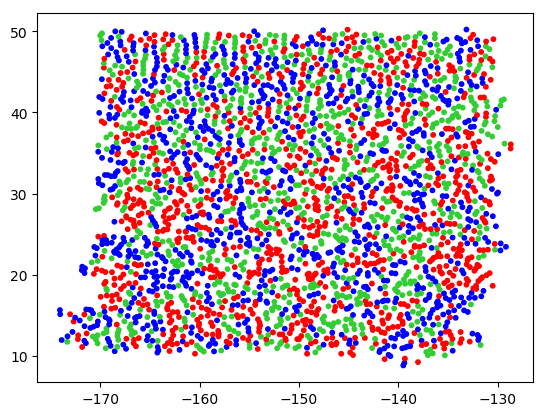

In [150]:
PyPlot.scatter(mlons, mlats, c=colors, s=10);

In [177]:
bins = 70

rock_distance_hist = zeros(Int, bins)
paper_distance_hist = zeros(Int, bins)
scissor_distance_hist = zeros(Int, bins)
all_distance_hist = zeros(Int, bins)

@time pairwise_distance_hist!(rock_mlats, rock_mlons, rock_distance_hist)
@time pairwise_distance_hist!(paper_mlats, paper_mlons, paper_distance_hist)
@time pairwise_distance_hist!(scissor_mlats, scissor_mlons, scissor_distance_hist)
@time pairwise_distance_hist!(mlats, mlons, all_distance_hist)

  0.055189 seconds (4 allocations: 160 bytes)
  0.041065 seconds (4 allocations: 160 bytes)
  0.049372 seconds (4 allocations: 160 bytes)
  0.417404 seconds (4 allocations: 160 bytes)


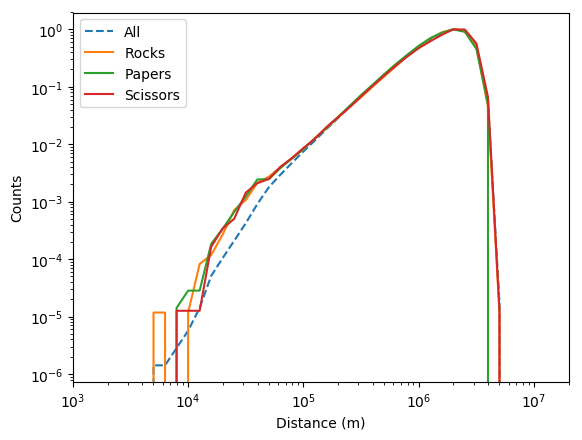

In [188]:
x = 10 .^ (collect(0:bins-1) ./ 10)

rock_distance_hist = convert(Array{Float64}, rock_distance_hist)
paper_distance_hist = convert(Array{Float64}, paper_distance_hist)
scissor_distance_hist = convert(Array{Float64}, scissor_distance_hist)
all_distance_hist = convert(Array{Float64}, all_distance_hist)

rock_distance_hist .= rock_distance_hist ./ maximum(rock_distance_hist)
paper_distance_hist .= paper_distance_hist ./ maximum(paper_distance_hist)
scissor_distance_hist .= scissor_distance_hist ./ maximum(scissor_distance_hist)
all_distance_hist .= all_distance_hist ./ maximum(all_distance_hist)

PyPlot.loglog(x, all_distance_hist, linestyle="--", label="All")
PyPlot.loglog(x, rock_distance_hist, label="Rocks")
PyPlot.loglog(x, paper_distance_hist, label="Papers")
PyPlot.loglog(x, scissor_distance_hist, label="Scissors")
# PyPlot.loglog(x, dist, linestyle="", marker=".")

PyPlot.xlabel("Distance (m)");
PyPlot.ylabel("Counts");
PyPlot.xlim([1e3, 2e7])

PyPlot.legend()

# PyPlot.plot([10^3, 10^5], [1e-5, 1e-1], label="slope=2");

In [225]:
rock_distance_hist = zeros(Int, bins)
paper_distance_hist = zeros(Int, bins)
scissor_distance_hist = zeros(Int, bins)
all_distance_hist = zeros(Int, bins)

pairwise_distance_hist!(rock_mlats, rock_mlons, rock_distance_hist)
pairwise_distance_hist!(paper_mlats, paper_mlons, paper_distance_hist)
pairwise_distance_hist!(scissor_mlats, scissor_mlons, scissor_distance_hist)
pairwise_distance_hist!(mlats, mlons, all_distance_hist)

rock_distance_histp = pairwise_distance_histogram_parallel(rock_mlats, rock_mlons, bins)
paper_distance_histp = pairwise_distance_histogram_parallel(paper_mlats, paper_mlons, bins)
scissor_distance_histp = pairwise_distance_histogram_parallel(scissor_mlats, scissor_mlons, bins)
all_distance_histp = pairwise_distance_histogram_parallel(mlats, mlons, bins)

@show rock_distance_histp ≈ rock_distance_hist;
@show paper_distance_histp ≈ paper_distance_hist;
@show scissor_distance_histp ≈ scissor_distance_hist;
@show all_distance_histp ≈ all_distance_hist;

rock_distance_histp ≈ rock_distance_hist = true
paper_distance_histp ≈ paper_distance_hist = true
scissor_distance_histp ≈ scissor_distance_hist = true
all_distance_histp ≈ all_distance_hist = true


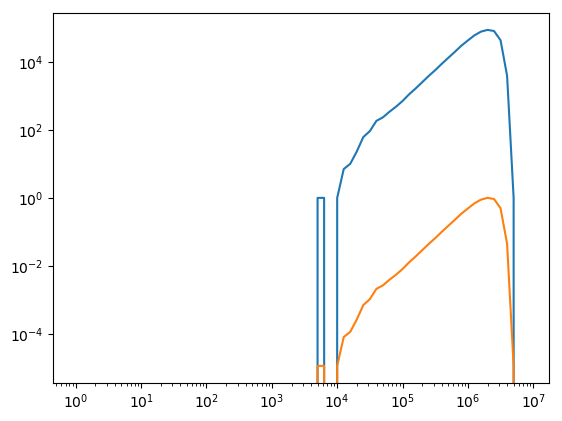

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000030290B38>

In [218]:
x = 10 .^ (collect(0:bins-1) ./ 10)
PyPlot.loglog(x, rock_dist_histp)
PyPlot.loglog(x, rock_distance_hist)